#0.0 IMPORTS

In [1]:
pip install boruta

     |████████████████████████████████| 56 kB 3.8 MB/s 


In [2]:
pip install kneed

In [3]:
!pip install tabulate

In [4]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as stats

import warnings
import random

from IPython.display         import Image
from tabulate                import tabulate
from sklearn.preprocessing   import RobustScaler,MinMaxScaler,LabelEncoder
from kneed                   import KneeLocator
from sklearn                 import metrics
from sklearn.cluster         import OPTICS, MiniBatchKMeans, MeanShift
from sklearn.cluster         import  AgglomerativeClustering, Birch, KMeans
from sklearn.mixture         import GaussianMixture
from sklearn.metrics         import davies_bouldin_score,calinski_harabasz_score
from sklearn.decomposition   import PCA

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

##0.1 Helper Functions

In [6]:
def ModelPerformance(n_features,X,yhat,model_name):
   
  cal = calinski_harabasz_score(X, yhat)
  db = davies_bouldin_score(X, yhat)  

  return  pd.DataFrame({ 'ModelName':         model_name,                                                 
                          'Db':                np.round(db,2),
                          'CalinskiHarabasz': np.round(cal,2)},index=[0]) 


  
def PlotClustering(data):

  for i in range(0,len(data['Clustering'].unique())):
    aux=data['Clustering'].unique()
    ax=sns.scatterplot(data=data[data['Clustering']==aux[i]], x='A', y='B', palette="deep")

  return ax



def CrossValidation(data, kfold, model_name, model):
    
  db_list=[]  
  calinski_harabasz_list=[]
    
  fim=[]
  inicio=[]  
  razao=data.index.max()/kfold
  for i in range(1,kfold+1):
    fim.append(round(razao*i,2))
    inicio.append(round((razao*i)-razao,2))

  for k in range(0,kfold):

    #Start and end for validation
    validation_start=inicio[k]
    validation_end=fim[k]

    #Filtering in dataset
    aux=data[(data.index>=validation_start) & (data.index<=validation_end)]
    training=data.drop(aux.index,axis=0)
    validation=data[(data.index>=validation_start) & (data.index<=validation_end)]
           
    #Model
    yhat=model.fit_predict(validation)   

    performaces=ModelPerformance(2,validation,yhat,model_name)
    
    #Performance of each KFold iteration
    db_list.append(performaces['Db'])
    calinski_harabasz_list.append(performaces['CalinskiHarabasz'])    


  return pd.DataFrame({ 'ModelName':             model_name,                                             
                        'Db CV':                  np.round(np.mean(db_list),2).astype(str)                + '+/-' + np.round(np.std(db_list),2).astype(str),
                        'CalinskiHarabasz CV':   np.round(np.mean(calinski_harabasz_list),2).astype(str) + '+/-' + np.round(np.std(calinski_harabasz_list),2).astype(str)},index=[0])
  

def NumericalCorrelation(numericos,data):

  columns=numericos.columns
  aux=data[columns]

  correlation=aux.corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);
  ax.figure.set_size_inches(8,4)
  ax.set_title('Correlação entre features numéricas',fontsize=14)

  return ax


def cramer_v(x,y):
  
  cm=pd.crosstab(x, y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def CategoricalCorrelation(data):

  #selecao
  a=data.select_dtypes(include='object')

  #lista 1 , todas correlacoes
  columns=a.columns
  lista=[]
  for i2 in range(0,len(columns)):
    for i in range(0,len(columns)):
      lista.append(cramer_v(a[columns[i2]],a[columns[i]]))

  #lista 2 , correlacoes por features
  lista2=[]
  n_features=len(columns)
  for i in range(0,n_features):

    a=n_features*i
    b=n_features*(i+1)

    lista2.append(lista[a:b])
  
  return lista2

##0.2 Loading Data

In [7]:
df_raw=pd.read_csv('/content/Ecommerce.csv',encoding = 'unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,nan
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,nan
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom,nan
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom,nan
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom,nan


# 1.0 PASSO 1 - DESCRIPTION OF THE DATA

In [8]:
#Copia do dataframe
df1=df_raw.copy()

##1.1 Rename Columns

In [9]:
names={ 'InvoiceNo':'NumeroFatura','StockCode':'CodigoStock','Description':'Produto',
        'Quantity':'Quantidade','InvoiceDate':'Data','UnitPrice':'Preco',
        'CustomerID':'IdCliente','Country':'Pais','Unnamed: 8':'Unnamed: 8'}

df1=df1.rename(columns=names)
df1.head(2)

,NumeroFatura,CodigoStock,Produto,Quantidade,Data,Preco,IdCliente,Pais,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,nan
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,nan


##1.2 Data Dimensions

In [10]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de columnas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de columnas: 9


##1.3 Data Types

In [11]:
df1.dtypes

NumeroFatura     object
CodigoStock      object
Produto          object
Quantidade        int64
Data             object
Preco           float64
IdCliente       float64
Pais             object
Unnamed: 8      float64
dtype: object

##1.4 Check NA

In [12]:
df1.isna().sum()

NumeroFatura         0
CodigoStock          0
Produto           1454
Quantidade           0
Data                 0
Preco                0
IdCliente       135080
Pais                 0
Unnamed: 8      541909
dtype: int64

##1.5 Fillout NA

In [13]:
df1=df1[df1['Produto'].isnull()==False]
df1=df1.drop(['Unnamed: 8'],axis=1)
df1['Quantidade']=df1['Quantidade'].apply(lambda x: x*(-1) if x<=0 else x)
df1['Preco']=df1['Preco'].apply(lambda x: x*(-1) if x<0 else x)
df1.isna().sum()

NumeroFatura         0
CodigoStock          0
Produto              0
Quantidade           0
Data                 0
Preco                0
IdCliente       133626
Pais                 0
dtype: int64

##1.6 Change types

In [14]:
#Data
df1['Data']=pd.to_datetime(df1['Data'])

##1.7 Descriptive Statistical

In [15]:
#num_attributes and cat_attributes
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

###1.7.1 Numerical Attributes

In [16]:
#Central tendency=mean,median
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion=std,min,max,range,skew,kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

#Concatenate
aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
aux.columns=(['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis'])   
aux

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,Quantidade,1.000,80995.000,10.225,11.225,3.000,217.930,337.220,120354.086
1,Preco,0.000,38970.000,4.705,4.705,2.080,96.886,197.294,58854.825
2,IdCliente,12346.000,18287.000,2941.691,15287.691,nan,1713.598,0.030,-1.180


In [17]:
df1=df1[df1['Preco']>0]

###1.7.2 Categorical attributes


In [18]:
cat_attributes.apply(lambda x:x.unique().shape[0])

NumeroFatura    24446
CodigoStock      3958
Produto          4223
Pais               38
dtype: int64

#2.0 PASSO 2 - FEATURE ENGINEERING

In [19]:
#copia do dataframe
df2=df1.copy()

##2.1 Mapa mental de Hipoteses

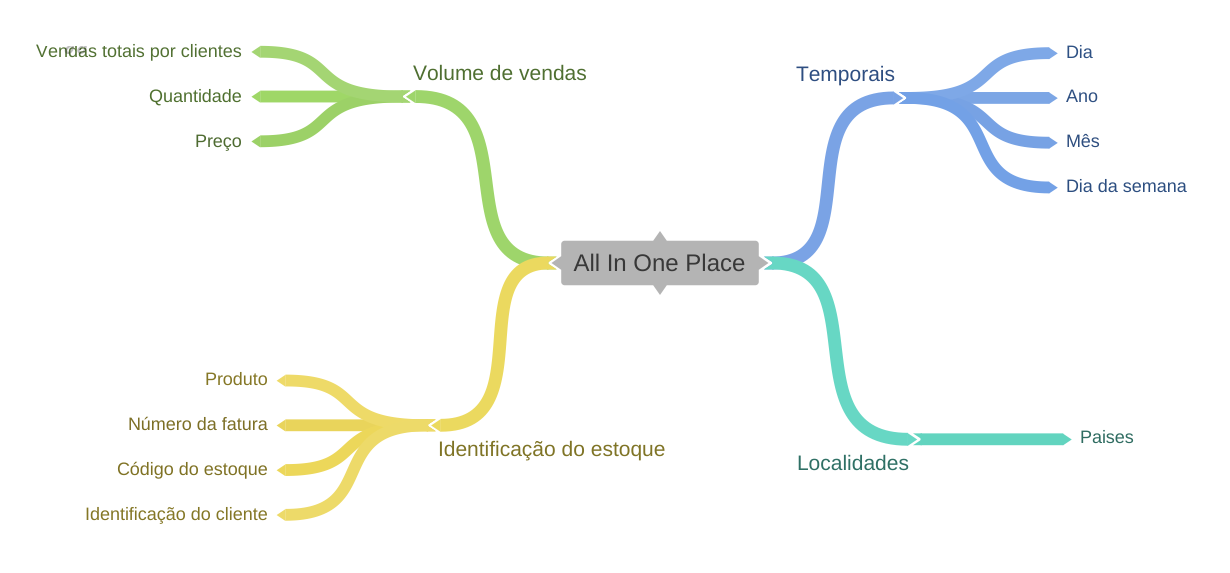

In [20]:
Image('/content/All In One Place.png')

##2.2 Criação das hipoteses

### 2.1.1 Hipoteses Temporais

**1.** As vendas aumentam ao longo dos anos

**2.** As vendas aumentam nos finais de ano (Setembro).

 **3.** As vendas aumentam no início do mês

 **4.** As vendas aumentam nos sabádos.

**5.** Clientes mais antigos tendem a comprar mais.

### 2.1.2 Hipoteses Localidades

**1.** O maior volume de compras está entre as regiões do Reino Unido, França  e Alemanha.

### 2.1.3 Hipoteses Volumes de vendas

**1.** Quanto menor o preço dos produtos maior e a quantidade vendidada

##2.3 Lista final de hipoteses

**H1-**As vendas aumentam ao longo dos anos.

**H2-**As vendas aumentam nos finais de ano (Setembro).

**H3-**As vendas aumentam no início do mês.

**H4-**As vendas aumentam nos sabádos.

**H5-**Clientes mais antigos tendem a comprar mais.

**H6-**O maior volume de compras está entre as regiões do Reino Unido, França  e Alemanha.

**H7-**Quanto menor o preço dos produtos maior e a quantidade vendidada.

##2.3 Feature Engineering

In [21]:
#Ano
df2['Ano']=df2['Data'].dt.year

#Mes
df2['Mes']=df2['Data'].dt.month

#Dia
df2['Dia']=df2['Data'].dt.day

#DiaDaSemana
df2['DiaDaSemana']=df2['Data'].dt.dayofweek

#ValorDaCompra
df2['ValorDaCompra']=df2['Quantidade']*df2['Preco']

#3.0. PASSO 3 - EXPLORATORY DATA ANALYSIS

In [22]:
#copia do dataframe
df3=df2.copy()

## 3.1 Univariate Analysis

###3.1.1. Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


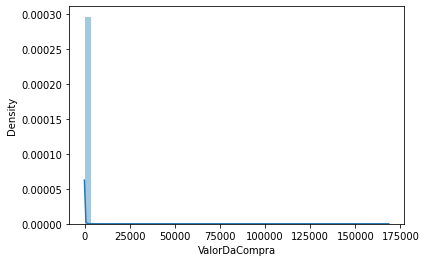

In [23]:
sns.distplot(df3['ValorDaCompra'])

###3.1.2. Numerical Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

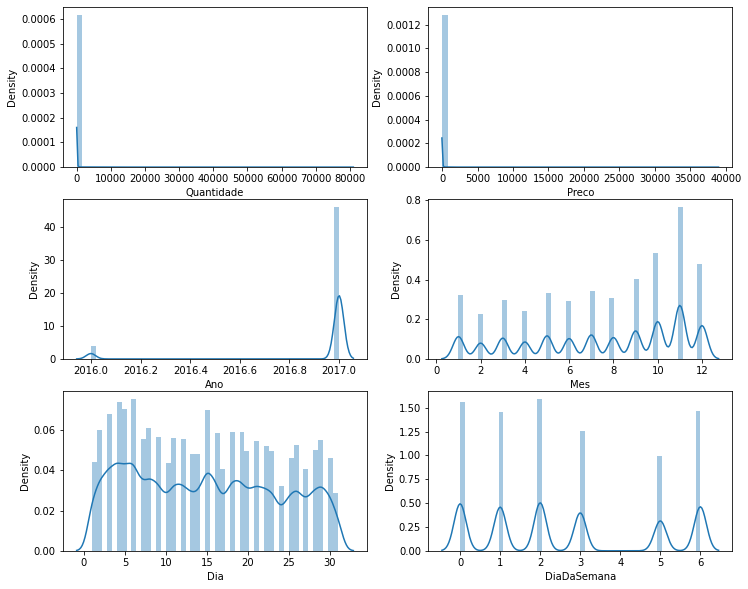

In [24]:
#Quantidade
plt.subplot(3,2,1)
ax=sns.distplot(df3['Quantidade'])
ax.figure.set_size_inches(12,10)

#Preco
plt.subplot(3,2,2)
ax=sns.distplot(df3['Preco'])

#Ano
plt.subplot(3,2,3)
ax=sns.distplot(df3['Ano'])

#Mes
plt.subplot(3,2,4)
ax=sns.distplot(df3['Mes'])

#Dia
plt.subplot(3,2,5)
ax=sns.distplot(df3['Dia'])

#DiaDaSemana
plt.subplot(3,2,6)
ax=sns.distplot(df3['DiaDaSemana'])

###3.1.3. Categorical Variable

Text(0.5, 1.0, 'Codigo do estoque mais utilizado')

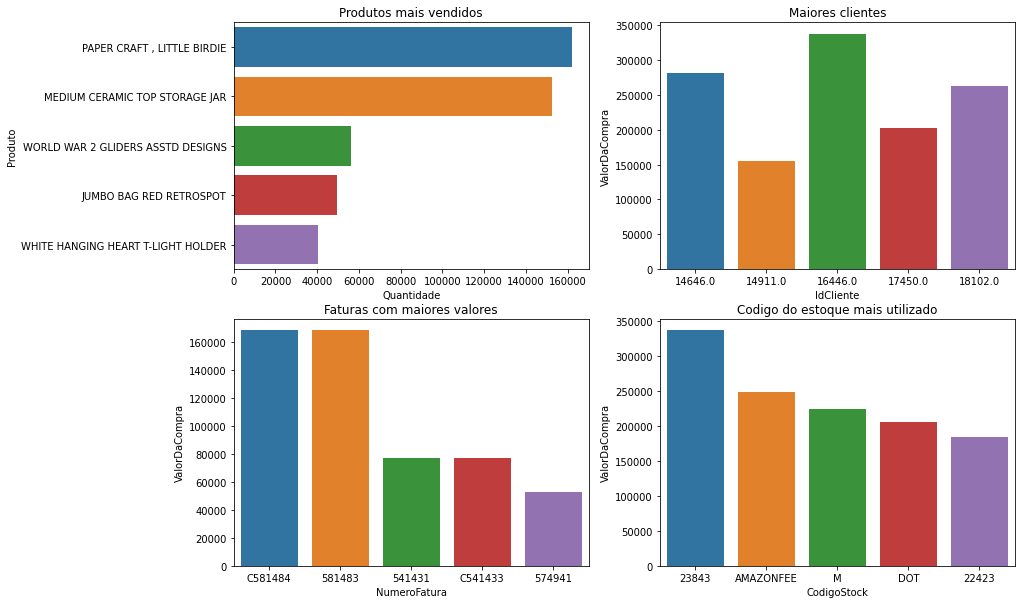

In [25]:
#Produto
plt.subplot(2,2,1)
aux=pd.DataFrame(data=df3.groupby('Produto')['Quantidade'].sum(),columns=['Quantidade']).sort_values('Quantidade',ascending=False).head(5)
ax=sns.barplot(y=aux.index,x='Quantidade',data=aux)
ax.figure.set_size_inches(14,10)
ax.set_title('Produtos mais vendidos')

#IdCliente
plt.subplot(2,2,2)
aux2=pd.DataFrame(data=df3.groupby('IdCliente')['ValorDaCompra'].sum(),columns=['ValorDaCompra']).sort_values('ValorDaCompra',ascending=False).head(5)
ax=sns.barplot(x=aux2.index,y='ValorDaCompra',data=aux2)
ax.set_title('Maiores clientes')

#NumeroFatura
plt.subplot(2,2,3)
aux3=pd.DataFrame(data=df3.groupby('NumeroFatura')['ValorDaCompra'].sum(),columns=['ValorDaCompra']).sort_values('ValorDaCompra',ascending=False).head(5)
ax=sns.barplot(x=aux3.index,y='ValorDaCompra',data=aux3)
ax.set_title('Faturas com maiores valores')

#CodigoStock
plt.subplot(2,2,4)
aux4=pd.DataFrame(data=df3.groupby('CodigoStock')['ValorDaCompra'].sum(),columns=['ValorDaCompra']).sort_values('ValorDaCompra',ascending=False).head(5)
ax=sns.barplot(x=aux4.index,y='ValorDaCompra',data=aux4)
ax.set_title('Codigo do estoque mais utilizado')

## 3.2 Bivariate Analysis

### ***H1***.As vendas aumentam ao longo dos anos.(TRUE)  


Text(0.5, 1.0, 'Vendas nos meses de Novembro e Dezembro')

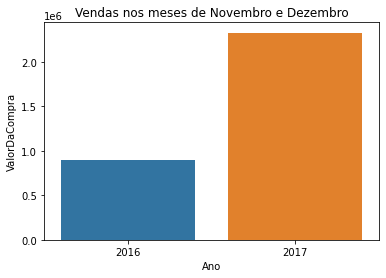

In [26]:
aux=df3[['Mes','Ano','ValorDaCompra']].groupby(['Ano','Mes']).sum().reset_index()
aux=aux[(aux['Mes']==11) | (aux['Mes']==12)]
aux=aux.groupby('Ano').sum().reset_index()

ax=sns.barplot(x='Ano',y='ValorDaCompra',data=aux)
ax.set_title('Vendas nos meses de Novembro e Dezembro')

### ***H2***. As vendas aumentam nos finais de ano (Setembro). (TRUE)

Text(0.5, 1.0, 'Vendas ao longo dos meses de 2017')

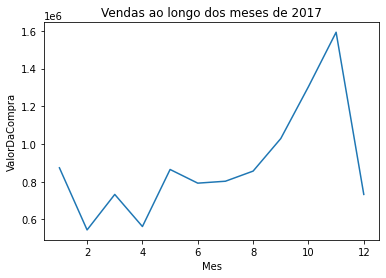

In [27]:
aux=df3[df3['Ano']==2017]
aux=aux.groupby('Mes').sum().reset_index()
ax=sns.lineplot(x='Mes',y='ValorDaCompra',data=aux)
ax.set_title('Vendas ao longo dos meses de 2017')

### ***H3***. As vendas aumentam no início do mês.(TRUE)

Text(0.5, 1.0, 'Soma de vendas por dia ')

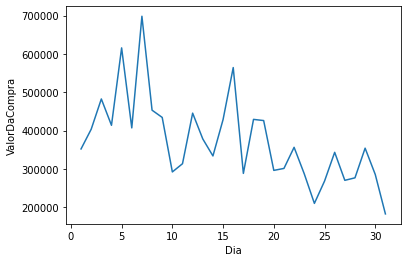

In [28]:
aux=df3.groupby('Dia').sum().reset_index()

sns.lineplot(x='Dia',y='ValorDaCompra',data=aux)
ax.set_title('Soma de vendas por dia ')

### ***H4***. As vendas aumentam nos sabádos.(FALSE)


Text(0.5, 1.0, 'Vendas por dia da semana')

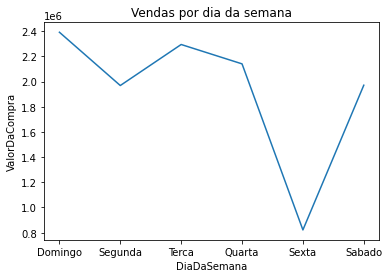

In [29]:
aux=df3[['DiaDaSemana','ValorDaCompra']].groupby('DiaDaSemana').sum().reset_index()
aux['DiaDaSemana']=aux['DiaDaSemana'].apply(lambda x : 'Domingo' if x==0 else 'Segunda' if x==1 else 
                                                       'Terca' if x==2 else 'Quarta' if x==3 else 'Quinta' if x==4 else
                                                       'Sexta' if x==5 else 'Sabado'  if x==6 else x)

ax=sns.lineplot(x='DiaDaSemana',y='ValorDaCompra',data=aux)
ax.set_title('Vendas por dia da semana')

### ***H5***.Clientes mais antigos tendem a comprar mais.(FALSE)


Text(0.5, 1.0, 'Valor da compra no tempo')

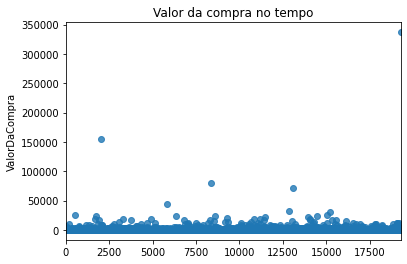

In [30]:
aux=df3[['IdCliente','Data','ValorDaCompra']].groupby(['IdCliente','Data']).sum().reset_index()
aux=aux.sort_values('Data',ascending=True).reset_index()

ax=sns.regplot(x=aux.index,y='ValorDaCompra',data=aux)
ax.set_title('Valor da compra no tempo')

### ***H6***.O maior volume de compras está entre as regiões do Reino Unido, França  e Alemanha.(TRUE)


Text(0.5, 1.0, 'Maiores compradores por paises')

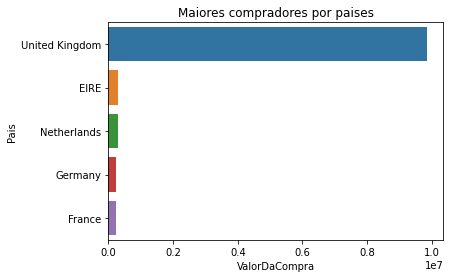

In [31]:
aux=df3[['Pais','ValorDaCompra']].groupby('Pais').sum().reset_index().sort_values('ValorDaCompra',ascending=False).head(5)

ax=sns.barplot(x='ValorDaCompra',y='Pais',data=aux)
ax.set_title('Maiores compradores por paises')

### ***H7***.Quanto menor o preço dos produtos maior é a quantidade vendidada. (FALSE)

Text(0.5, 1.0, 'Preco x Quantidade vendida')

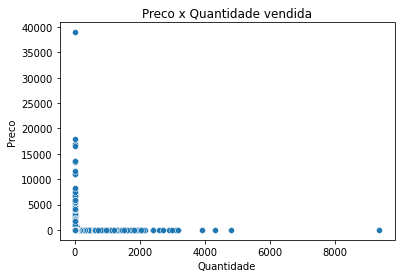

In [32]:
ax=sns.scatterplot(y='Preco',x='Quantidade',data=df3[df3['Quantidade']<10000])
ax.set_title('Preco x Quantidade vendida')

### 3.2.1 Summary of hypotheses

In [69]:
tab=[['Hipoteses','conclusao','Relevancia'],
     ['H1','True','Media'],
     ['H2','True','Alta'],
     ['H3','True','Media'],
     ['H4','False','Baixa'],
     ['H5','False','Baixa'],
     ['H6','True','Baixa'],
     ['H7','False','Baixa'],]

print(tabulate(tab,headers='firstrow'))

Hipoteses    conclusao    Relevancia
-----------  -----------  ------------
H1           True         Media
H2           True         Alta
H3           True         Media
H4           False        Baixa
H5           False        Baixa
H6           True         Baixa
H7           False        Baixa


## 3.3 Multivariate Analysis

###3.3.1. Numerical Atributes

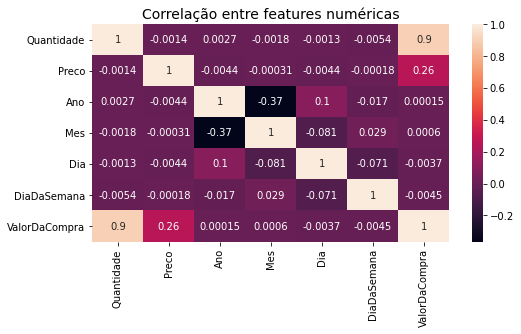

In [34]:
NumericalCorrelation(df3[['Quantidade','Preco','Ano','Mes','Dia','DiaDaSemana','ValorDaCompra']],df3)

###3.3.2. Categorical Atributes

In [35]:
lista=CategoricalCorrelation(df3[['Pais','Produto']])

d=pd.DataFrame({'Pais':                           lista[0],
                'Produto':                        lista[1]                             
                })

d=d.set_index(d.columns)

d.head()

,Pais,Produto
Pais,1.000,0.112
Produto,0.112,1.004


#4.0. PASSO 4 - DATA PREPARATION

In [36]:
#copia do dataframe
df4=df3.copy()

##4.2. Rescaling

In [37]:
rs=RobustScaler()
mm=MinMaxScaler()

#RobustScaler
#Quantidade
df4['Quantidade']=rs.fit_transform(df4[['Quantidade']].values)


#MinMaxScaler
#Ano
df4['Ano']=mm.fit_transform(df4[['Ano']])

#Mes
df4['Mes']=mm.fit_transform(df4[['Mes']].values)

#Dia
df4['Dia']=mm.fit_transform(df4[['Dia']].values)

#Preco
df4['Preco']=np.log1p(df4['Preco'])

#ValorDaCompra
df4['ValorDaCompra']=np.log1p(df4['ValorDaCompra'])

## 4.3. Transformation

###4.3.1. Encoding

In [38]:
#Label Enconding
le=LabelEncoder()
#NumeroFatura
df4['NumeroFatura']=le.fit_transform(df4['NumeroFatura'])

#CodigoStock
df4['CodigoStock']=le.fit_transform(df4['CodigoStock'])

#Produto
df4['Produto']=le.fit_transform(df4['Produto'])

#Pais
df4['Pais']=le.fit_transform(df4['Pais'])

###4.3.2. Nature transformation

In [39]:
#Mes
df4['MesSin']=df4['Mes'].apply(lambda x:np.sin(x*(2.*np.pi/12)))
df4['MesCos']=df4['Mes'].apply(lambda x:np.cos(x*(2.*np.pi/12)))

#Dia
df4['DiaSin']=df4['Dia'].apply(lambda x:np.sin(x*(2.*np.pi/30)))
df4['DiaCos']=df4['Dia'].apply(lambda x:np.cos(x*(2.*np.pi/30)))

#DiaDaSemana
df4['DiaDaSemanaSin']=df4['DiaDaSemana'].apply(lambda x:np.sin(x*(2.*np.pi/7)))
df4['DiaDaSemanaCos']=df4['DiaDaSemana'].apply(lambda x:np.cos(x*(2.*np.pi/7)))

df4=df4.drop(['Mes','Dia','DiaDaSemana'],axis=1)

#5.0. PASSO 5 - MACHINE LEARNING MODELLING

In [40]:
#Copy dataframe
df5=df4[['NumeroFatura', 'CodigoStock', 'Produto']].copy()

#Dimensionality reduction
pca = PCA(n_components=2)
pca_reduction=pca.fit_transform(df5) 
pca_reduction=pd.DataFrame(data=pca_reduction,columns=['A','B'])

#Defining number of clusters
sse = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_reduction)
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(1, 13), sse, curve="convex", direction="decreasing" )
n_clusters=int(kl.elbow)
print('Número de clusters: {}'.format(n_clusters))

'#Defining number of clusters\nsse = []\nfor k in range(1, 13):\n    kmeans = KMeans(n_clusters=k)\n    kmeans.fit(pca_reduction)\n    sse.append(kmeans.inertia_)\n\nkl = KneeLocator(range(1, 13), sse, curve="convex", direction="decreasing" )\nn_clusters=int(kl.elbow)\nprint(\'Número de clusters: {}\'.format(n_clusters))'

##5.1. Kmeans

In [41]:
#model
kmeans=KMeans(n_clusters=n_clusters,init='random')

#training
kmeans_training=kmeans.fit(pca_reduction)

#predictions
yhat_kmeans=kmeans_training.predict(pca_reduction)

#concat predictions
yhat_kmeans=pd.DataFrame(data=yhat_kmeans,columns=['Clustering'])
yhat_kmeans=pd.concat([pca_reduction,yhat_kmeans],axis=1)

#plot clustering
kmeans_results=ModelPerformance(2,yhat_kmeans[['A','B']],yhat_kmeans['Clustering'],'kmeans')
kmeans_results

"#model\nkmeans=KMeans(n_clusters=n_clusters,init='random')\n\n#training\nkmeans_training=kmeans.fit(pca_reduction)\n\n#predictions\nyhat_kmeans=kmeans_training.predict(pca_reduction)\n\n#concat predictions\nyhat_kmeans=pd.DataFrame(data=yhat_kmeans,columns=['Clustering'])\nyhat_kmeans=pd.concat([pca_reduction,yhat_kmeans],axis=1)\n\n#plot clustering\nkmeans_results=ModelPerformance(2,yhat_kmeans[['A','B']],yhat_kmeans['Clustering'],'kmeans')\nkmeans_results"

###5.1.2. Kmeans cross validation

In [42]:
kmeans_results_cv=CrossValidation(pca_reduction,5,'kmeans',kmeans)
kmeans_results_cv
PlotClustering(yhat_kmeans)

"kmeans_results_cv=CrossValidation(pca_reduction,5,'kmeans',kmeans)\nkmeans_results_cv\nPlotClustering(yhat_kmeans)"

##5.2. OPTICS


In [43]:
#Model
op=OPTICS(eps=0.8, min_samples=10)

#Predictions
yhat_op=op.fit_predict(pca_reduction)

#Concat predictions
yhat_op=pd.DataFrame(data=yhat_op,columns=['Clustering'])
yhat_op=pd.concat([pca_reduction,yhat_op],axis=1)

op_results=ModelPerformance(2,yhat_op[['A','B']],yhat_op['Clustering'],'optics')
op_results

"#Model\nop=OPTICS(eps=0.8, min_samples=10)\n\n#Predictions\nyhat_op=op.fit_predict(pca_reduction)\n\n#Concat predictions\nyhat_op=pd.DataFrame(data=yhat_op,columns=['Clustering'])\nyhat_op=pd.concat([pca_reduction,yhat_op],axis=1)\n\nop_results=ModelPerformance(2,yhat_op[['A','B']],yhat_op['Clustering'],'optics')\nop_results"

###5.2.2. OPTICS cross validation

In [44]:
op_results_cv=CrossValidation(pca_reduction,5,'Optics',op)
op_results_cv
PlotClustering(yhat_op)

"op_results_cv=CrossValidation(pca_reduction,5,'Optics',op)\nop_results_cv\nPlotClustering(yhat_op)"

##5.3. Mini-Batch K-Means


In [45]:
#Model
mbkm = MiniBatchKMeans(n_clusters=n_clusters)

#Training
mbkm_training=mbkm.fit(pca_reduction)

#Prediction
yhat_mbkm = mbkm_training.predict(pca_reduction)

#Concat predictions
yhat_mbkm=pd.DataFrame(data=yhat_mbkm,columns=['Clustering'])
yhat_mbkm=pd.concat([pca_reduction,yhat_mbkm],axis=1)

mbkm_results=ModelPerformance(2,yhat_mbkm[['A','B']],yhat_mbkm['Clustering'],'Mini-Batch')
mbkm_results

"#Model\nmbkm = MiniBatchKMeans(n_clusters=n_clusters)\n\n#Training\nmbkm_training=mbkm.fit(pca_reduction)\n\n#Prediction\nyhat_mbkm = mbkm_training.predict(pca_reduction)\n\n#Concat predictions\nyhat_mbkm=pd.DataFrame(data=yhat_mbkm,columns=['Clustering'])\nyhat_mbkm=pd.concat([pca_reduction,yhat_mbkm],axis=1)\n\nmbkm_results=ModelPerformance(2,yhat_mbkm[['A','B']],yhat_mbkm['Clustering'],'Mini-Batch')\nmbkm_results"

###5.3.2. Mini-Batch K-Means cross validation

In [46]:
mbkm_results_cv=CrossValidation(pca_reduction,5,'Mini-Batch K-Means',mbkm)
mbkm_results_cv
PlotClustering(yhat_mbkm)

"mbkm_results_cv=CrossValidation(pca_reduction,5,'Mini-Batch K-Means',mbkm)\nmbkm_results_cv\nPlotClustering(yhat_mbkm)"

##5.4. Mean Shift



In [47]:
#Model
ms = MeanShift()

#Prediction
yhat_ms = ms.fit_predict(pca_reduction)

#Concat predictions
yhat_ms=pd.DataFrame(data=yhat_ms,columns=['Clustering'])
yhat_ms=pd.concat([pca_reduction,yhat_ms],axis=1)

ms_results=ModelPerformance(2,yhat_ms[['A','B']],yhat_ms['Clustering'],'Mean Shift')
ms_results

"#Model\nms = MeanShift()\n\n#Prediction\nyhat_ms = ms.fit_predict(pca_reduction)\n\n#Concat predictions\nyhat_ms=pd.DataFrame(data=yhat_ms,columns=['Clustering'])\nyhat_ms=pd.concat([pca_reduction,yhat_ms],axis=1)\n\nms_results=ModelPerformance(2,yhat_ms[['A','B']],yhat_ms['Clustering'],'Mean Shift')\nms_results"

###5.4.2. Mean Shift cross validation

In [48]:
ms_results_cv=CrossValidation(pca_reduction,5,'Mean Shift',ms)
ms_results_cv
PlotClustering(yhat_ms)

"ms_results_cv=CrossValidation(pca_reduction,5,'Mean Shift',ms)\nms_results_cv\nPlotClustering(yhat_ms)"

##5.5. Gaussian Mixture 

In [49]:
#Model
gm = GaussianMixture(n_components=n_clusters)

#Training
gm_training=gm.fit(pca_reduction)

#Prediction
yhat_gm = gm_training.predict(pca_reduction)

#Concat predictions
yhat_gm=pd.DataFrame(data=yhat_gm,columns=['Clustering'])
yhat_gm=pd.concat([pca_reduction,yhat_gm],axis=1)

gm_results=ModelPerformance(2,yhat_gm[['A','B']],yhat_gm['Clustering'],'Gaussian Mixture')
gm_results

"#Model\ngm = GaussianMixture(n_components=n_clusters)\n\n#Training\ngm_training=gm.fit(pca_reduction)\n\n#Prediction\nyhat_gm = gm_training.predict(pca_reduction)\n\n#Concat predictions\nyhat_gm=pd.DataFrame(data=yhat_gm,columns=['Clustering'])\nyhat_gm=pd.concat([pca_reduction,yhat_gm],axis=1)\n\ngm_results=ModelPerformance(2,yhat_gm[['A','B']],yhat_gm['Clustering'],'Gaussian Mixture')\ngm_results"

###5.5.2. Gaussian Mixture cross validation

In [50]:
gm_results_cv=CrossValidation(pca_reduction,5,'Gaussian Mixture',gm)
gm_results_cv
PlotClustering(yhat_gm)

"gm_results_cv=CrossValidation(pca_reduction,5,'Gaussian Mixture',gm)\ngm_results_cv\nPlotClustering(yhat_gm)"

##5.6. BIRCH

In [51]:
#Model
bc = Birch(threshold=0.01, n_clusters=n_clusters)

#Prediction
yhat_bc = bc.fit_predict(pca_reduction)

#Concat predictions
yhat_bc=pd.DataFrame(data=yhat_bc,columns=['Clustering'])
yhat_bc=pd.concat([pca_reduction,yhat_bc],axis=1)

bc_results=ModelPerformance(2,yhat_bc[['A','B']],yhat_bc['Clustering'],'Gaussian Mixture')
bc_results

"#Model\nbc = Birch(threshold=0.01, n_clusters=n_clusters)\n\n#Prediction\nyhat_bc = bc.fit_predict(pca_reduction)\n\n#Concat predictions\nyhat_bc=pd.DataFrame(data=yhat_bc,columns=['Clustering'])\nyhat_bc=pd.concat([pca_reduction,yhat_bc],axis=1)\n\nbc_results=ModelPerformance(2,yhat_bc[['A','B']],yhat_bc['Clustering'],'Gaussian Mixture')\nbc_results"

###5.6.2. BIRCH cross validation

In [52]:
bc_results_cv=CrossValidation(pca_reduction,5,'BIRCH',bc)
bc_results_cv
PlotClustering(yhat_bc)

"bc_results_cv=CrossValidation(pca_reduction,5,'BIRCH',bc)\nbc_results_cv\nPlotClustering(yhat_bc)"

##5.7. Agglomerative Clustering

In [53]:
#Model
ac=AgglomerativeClustering(n_clusters=n_clusters)

#Predictions
yhat_ac=ac.fit_predict(pca_reduction)

#Concat predictions
yhat_ac=pd.DataFrame(data=yhat_ac,columns=['Clustering'])
yhat_ac=pd.concat([pca_reduction,yhat_ac],axis=1)

ac_results=ModelPerformance(2,yhat_ac[['A','B']],yhat_ac['Clustering'],'AgglomerativeClustering')
ac_results

"#Model\nac=AgglomerativeClustering(n_clusters=n_clusters)\n\n#Predictions\nyhat_ac=ac.fit_predict(pca_reduction)\n\n#Concat predictions\nyhat_ac=pd.DataFrame(data=yhat_ac,columns=['Clustering'])\nyhat_ac=pd.concat([pca_reduction,yhat_ac],axis=1)\n\nac_results=ModelPerformance(2,yhat_ac[['A','B']],yhat_ac['Clustering'],'AgglomerativeClustering')\nac_results"

###5.7.2. Agglomerative clustering cross validation

In [54]:
ac_results_cv=CrossValidation(pca_reduction,5,'agglomerative clustering',ac)
ac_results_cv
PlotClustering(yhat_ac)

"ac_results_cv=CrossValidation(pca_reduction,5,'agglomerative clustering',ac)\nac_results_cv\nPlotClustering(yhat_ac)"

##5.8. Compare Model's Performance

### 5.8.1. Single Performance


In [55]:
modelling_results=pd.concat([kmeans_results,op_results,mbkm_results,
                             ms_results,gm_results,bc_results,ac_results],axis=0)
modelling_results.sort_values('Db',ascending=False)

"modelling_results=pd.concat([kmeans_results,op_results,mbkm_results,\n                             ms_results,gm_results,bc_results,ac_results],axis=0)\nmodelling_results.sort_values('Db',ascending=False)"

###5.8.2. Real Performance - Cross Validation


In [56]:
modelling_results_cv=pd.concat([kmeans_results_cv,op_results_cv,mbkm_results_cv,ms_results_cv,gm_results_cv,
                                bc_results_cv,ac_results_cv,],axis=0)
modelling_results_cv.sort_values('Db CV',ascending=False)
plt.subplot(3,3,1)
ax=PlotClustering(yhat_kmeans)
ax.figure.set_size_inches(12,12)
ax.set_title('kemans')

plt.subplot(3,3,2)
ax=PlotClustering(yhat_op)
ax.set_title('OPTICS')

plt.subplot(3,3,3)
ax=PlotClustering(yhat_mbkm)
ax.set_title('Mini-Batch K-Means')

plt.subplot(3,3,4)
ax=PlotClustering(yhat_ms)
ax.set_title('Mean-Shift')

plt.subplot(3,3,5)
ax=PlotClustering(yhat_gm)
ax.set_title('Gaussian Mixture')

plt.subplot(3,3,6)
ax=PlotClustering(yhat_bc)
ax.set_title('BIRCH')

plt.subplot(3,3,7)
ax=PlotClustering(yhat_ac)
ax.set_title('Agglomerative clustering')

"modelling_results_cv=pd.concat([kmeans_results_cv,op_results_cv,mbkm_results_cv,ms_results_cv,gm_results_cv,\n                                bc_results_cv,ac_results_cv,],axis=0)\nmodelling_results_cv.sort_values('Db CV',ascending=False)\nplt.subplot(3,3,1)\nax=PlotClustering(yhat_kmeans)\nax.figure.set_size_inches(12,12)\nax.set_title('kemans')\n\nplt.subplot(3,3,2)\nax=PlotClustering(yhat_op)\nax.set_title('OPTICS')\n\nplt.subplot(3,3,3)\nax=PlotClustering(yhat_mbkm)\nax.set_title('Mini-Batch K-Means')\n\nplt.subplot(3,3,4)\nax=PlotClustering(yhat_ms)\nax.set_title('Mean-Shift')\n\nplt.subplot(3,3,5)\nax=PlotClustering(yhat_gm)\nax.set_title('Gaussian Mixture')\n\nplt.subplot(3,3,6)\nax=PlotClustering(yhat_bc)\nax.set_title('BIRCH')\n\nplt.subplot(3,3,7)\nax=PlotClustering(yhat_ac)\nax.set_title('Agglomerative clustering')"

#6.0. PASSO 6 - HYPERPARAMETER FINE TUNING

In [57]:
#copia do dataframe
df6=df5.copy()

##6.1.Random Search

In [58]:
warnings.filterwarnings('ignore')

In [59]:
#params
param={        'n_clusters':  [2,3,4],
               'tol':         [0.0001,0.001,0.01],
               'max_iter':    [100,200,300],
               'tol':         [0.0001,0.001,0.01],
               'verbose':     [0,1,2]}

MAX_EVAL=25

final_results=pd.DataFrame()

for i in range (MAX_EVAL):

  #Choose values for parameters randomly
  hp={k:random.sample(v,1)[0] for k,v in param.items()}
  print(hp)

  #model
  kmeans_model=KMeans(init='random',   n_clusters=  hp['n_clusters'],
                                       tol=         hp['tol'],
                                       max_iter=    hp['max_iter'],
                                       verbose=     hp['verbose'])             
                            
  
  #performance
  results=CrossValidation(pca_reduction,5,'K-Means',kmeans_model) 
  final_results=pd.concat([final_results,results])
final_results

"#params\nparam={        'n_clusters':  [2,3,4],\n               'tol':         [0.0001,0.001,0.01],\n               'max_iter':    [100,200,300],\n               'tol':         [0.0001,0.001,0.01],\n               'verbose':     [0,1,2]}\n\nMAX_EVAL=25\n\nfinal_results=pd.DataFrame()\n\nfor i in range (MAX_EVAL):\n\n  #Choose values for parameters randomly\n  hp={k:random.sample(v,1)[0] for k,v in param.items()}\n  print(hp)\n\n  #model\n  kmeans_model=KMeans(init='random',   n_clusters=  hp['n_clusters'],\n                                       tol=         hp['tol'],\n                                       max_iter=    hp['max_iter'],\n                                       verbose=     hp['verbose'])             \n                            \n  \n  #performance\n  results=CrossValidation(pca_reduction,5,'K-Means',kmeans_model) \n  final_results=pd.concat([final_results,results])\nfinal_results"

##6.2.Final Model

,ModelName,Db CV,CalinskiHarabasz CV
0,K-Means,0.82+/-0.04,138766.74+/-68294.99


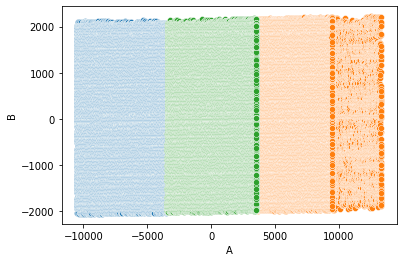

In [60]:
#Params tuned
params_tuned={'n_clusters': 3, 'tol': 0.001, 'max_iter': 200, 'verbose': 0}

#Model
kmeans_model_tuned=KMeans(         init='random',
                                   n_clusters=  params_tuned['n_clusters'],
                                   tol=         params_tuned['tol'],
                                   max_iter=    params_tuned['max_iter'],
                                   verbose=     params_tuned['verbose']) 

#Prediction
yhat_model_tuned=kmeans_model_tuned.fit_predict(pca_reduction)

#Concat predictions
yhat_model_tuned=pd.DataFrame(data=yhat_model_tuned,columns=['Clustering'])
yhat_model_tuned=pd.concat([pca_reduction,yhat_model_tuned],axis=1)

#plot clustering
PlotClustering(yhat_model_tuned)

#Performance
kmeans_result_cv=CrossValidation(pca_reduction,5,'K-Means',kmeans_model_tuned)
kmeans_result_cv

#7.0. PASSO 7 - REPORT

In [61]:
df7=pd.concat([df3.copy().reset_index(),yhat_model_tuned['Clustering']],axis=1)
df7['Clustering']=df7['Clustering'].apply(lambda x: 'G1' if x==0 else 'G2' if x==1 else 'G3' if x==2 else x)

### 1 - Quem são as pessoas elegíveis para participar do programa de Insiders ?


Text(0.5, 1.0, 'Vendas por grupos')

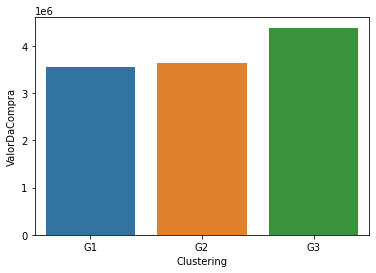

In [62]:
aux=df7[['Clustering','ValorDaCompra']].copy().groupby('Clustering').sum().reset_index()

sns.barplot(x='Clustering',y='ValorDaCompra',data=aux)
ax.set_title('Vendas por grupos')

### 2 - Quantos clientes farão parte do grupo?

In [63]:
len(df7[df7['Clustering']=='G2']['IdCliente'].unique())

2586

### 3 - Quais as principais características desses clientes ?

Text(0.5, 1.0, 'Vendas Do Grupo 2 em 2017')

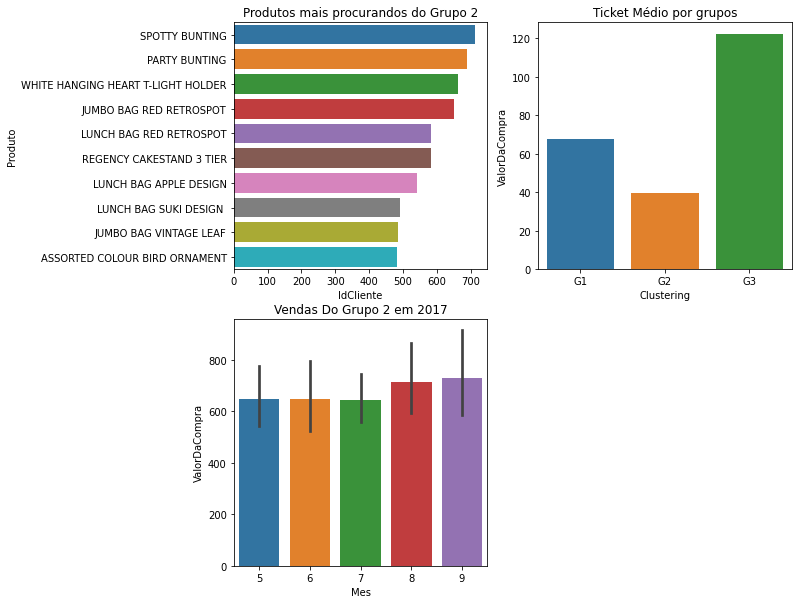

In [64]:
#Produtos mais procurandos do Grupo 2
aux=df7[df7['Clustering']=='G2']
aux=aux[['IdCliente','Produto']].groupby('Produto').count().reset_index().sort_values('IdCliente',ascending=False).head(10)

plt.subplot(2,2,1)
ax=sns.barplot(y='Produto',x='IdCliente',data=aux)
ax.set_title('Produtos mais procurandos do Grupo 2')
ax.figure.set_size_inches(10,10)

#Ticket Médio por grupos
aux=df7[['IdCliente','Clustering','ValorDaCompra']].groupby(['Clustering','IdCliente']).mean().reset_index()
aux=aux.groupby(['Clustering']).mean().reset_index()

plt.subplot(2,2,2)
ax=sns.barplot(x='Clustering',y='ValorDaCompra',data=aux)
ax.set_title('Ticket Médio por grupos')

#Vendas Do Grupo 2 em 2017
aux=df7[(df7['Clustering']=='G2')& (df7['Ano']==2017)]
aux=aux[['IdCliente','Mes','ValorDaCompra']].groupby(['IdCliente','Mes']).sum().reset_index()

plt.subplot(2,2,3)
ax=sns.barplot(x='Mes',y='ValorDaCompra',data=aux)
ax.set_title('Vendas Do Grupo 2 em 2017')

##### 1 - Consomem produtos para festas

##### 2 - Possuem o ticket médio superior

##### 3 - Compram mais nos meses de Outubro , Novembro e Dezembro.

### 4 - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?


In [65]:
aux=df7[['Clustering','ValorDaCompra']].groupby('Clustering').sum().reset_index()
aux['%']=(aux['ValorDaCompra']/aux['ValorDaCompra'].sum())*100
aux

,Clustering,ValorDaCompra,%
0,G1,3562329.231,30.748
1,G2,3637519.353,31.397
2,G3,4385772.570,37.855


### 5 - Qual a expectativa de faturamento desse grupo para os próximos 6 meses ?


In [66]:
aux=df7[(df7['Clustering']=='G2') & (df7['Ano']==2017)]
aux=aux[['Mes','ValorDaCompra']].groupby('Mes').sum().reset_index().head(6)

aux['PiorSenario']=(aux['ValorDaCompra'].mean()-np.std(aux['ValorDaCompra']))*6
aux['ValorEsperado']=aux['ValorDaCompra'].mean()*6
aux['MelhorSenario']=(aux['ValorDaCompra'].mean()+np.std(aux['ValorDaCompra']))*6
aux=aux[['PiorSenario','ValorEsperado','MelhorSenario']].head(1)
aux

,PiorSenario,ValorEsperado,MelhorSenario
0,3810574.319,4365023.224,4919472.128


### 6 - Quais as condições para uma pessoa ser elegível ao Insiders ?


#### 1 - Ter ticket médio acima de 100 dólares no ano de 2017

###7 - Quais as condições para uma pessoa ser removida do Insiders ?


#### 1- Possuir um ticket médio anual abaixo de 100 dólares
#### 2- Ficar 2 meses sem comprar.

### 8 - Qual a garantia que o programa Insiders é melhor que o restante da base ?

In [67]:
aux=df7[['Clustering','ValorDaCompra']].groupby('Clustering').sum().reset_index()
aux['%']=(aux['ValorDaCompra']/aux['ValorDaCompra'].sum())*100
media=aux['%'].mean()
percentual_acima=g2=aux['%']-media
percentual_acima[1]

-1.9364897403258823

#### Os Insiders compram o ano todo e possuem faturamento de 5 % maior do que os outros grupos.

###9 - Quais ações o time de marketing pode realizar para aumentar o faturamento?


#### Fazer campanhas de marketing visando os produtos para festas.